## CS484 Final Project: Image inpainting using Object removal
Image inpainting is the process of filling in missing information from an image. One application of this is restoring damaged photographs that have been digitized. If a photograph has been folded or creased, inpainting can fill in and restore those damaged areas. Another application is object removal, where the unwanted object is erased from the image, and then the background is inpainted in where the object used to be. The human brain does inpainting, since there is a blind spot on the retina where the optic nerve connects, but the brain “inpaints” that blind spot so it is not perceptible.

In this report we will be demonstrating several techniques for inpainting, ranging from simple to complex.


Team members:
   - Sophia Deak (sijdeak@uwaterloo.ca) : Data augmentation and gathering. Data loader creation. Styling and cleaning the code. Training the base AE. Simple inpainting methods 
   - Arvin Asgharian (a29agha@uwaterloo.ca) : Developing the Unet and basic Ae architecture. research and data gathering. training and hyperparameter tuninng

#### Section 1: Data gathering and cleaning
The data is loaded from deeplake, and stored in an array. The dataset used is a subset of Places205, which contains ~2.5 million images of various indoor and outdoor scenes. It is commonly used for image classification.

In [ ]:
! pip install "deeplake<4.0"

In [ ]:
# Torch Imports
import torch
from torch.utils.data import DataLoader
import torchvision.io as tvio
import torchvision.transforms as tfs
import torchvision.transforms.functional as tF
from torch.optim import Optimizer

# numpy and other tools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# our Implementations
from utility_functions import RandomHFlip, RandomVFlip, PairAddWhiteNoise, PairToTensors, CrossMask, RectangleMask, torch_image_to_numpy, thinXMask, thickXMask, showResults
from dataset import CustomPlaces
from train import train_AE, getOptim, train_Unet
from download_dataset import DatasetDownloader
from basic_methods import nearestNeighbors, gaussianInpaint


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Section 2: Simple mathematical inpainting

Two simple ways to do inpainting is using gaussian blur, and nearest neighbors

Similar to clone stamp on photoshop


#### Set up images and masks

In [3]:
abbey = np.mean(np.load('images/abbey0.jpg.npy'), axis=2)

thinMask = thinXMask(abbey)
thickMask = thickXMask(abbey)

abbeyDamaged = abbey.copy()
abbeyDamaged[thinMask == 1] = 255

abbeyDamaged2 = abbey.copy()
abbeyDamaged2[thickMask == 1] = 255


#### Nearest Neighbors

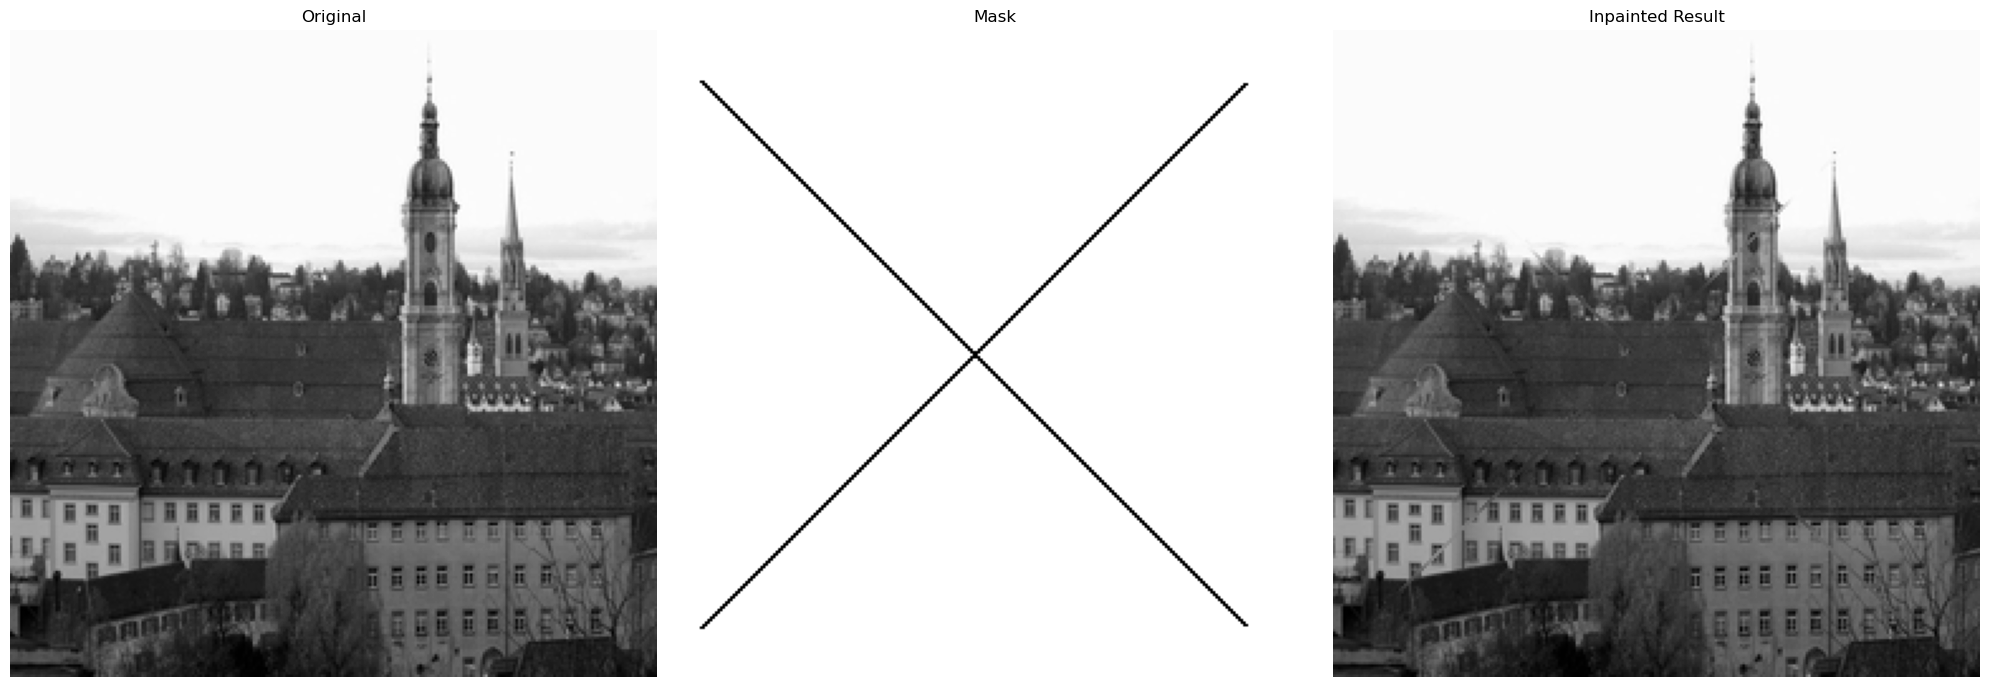

In [29]:

inpainted_image = nearestNeighbors(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, inpainted_image)

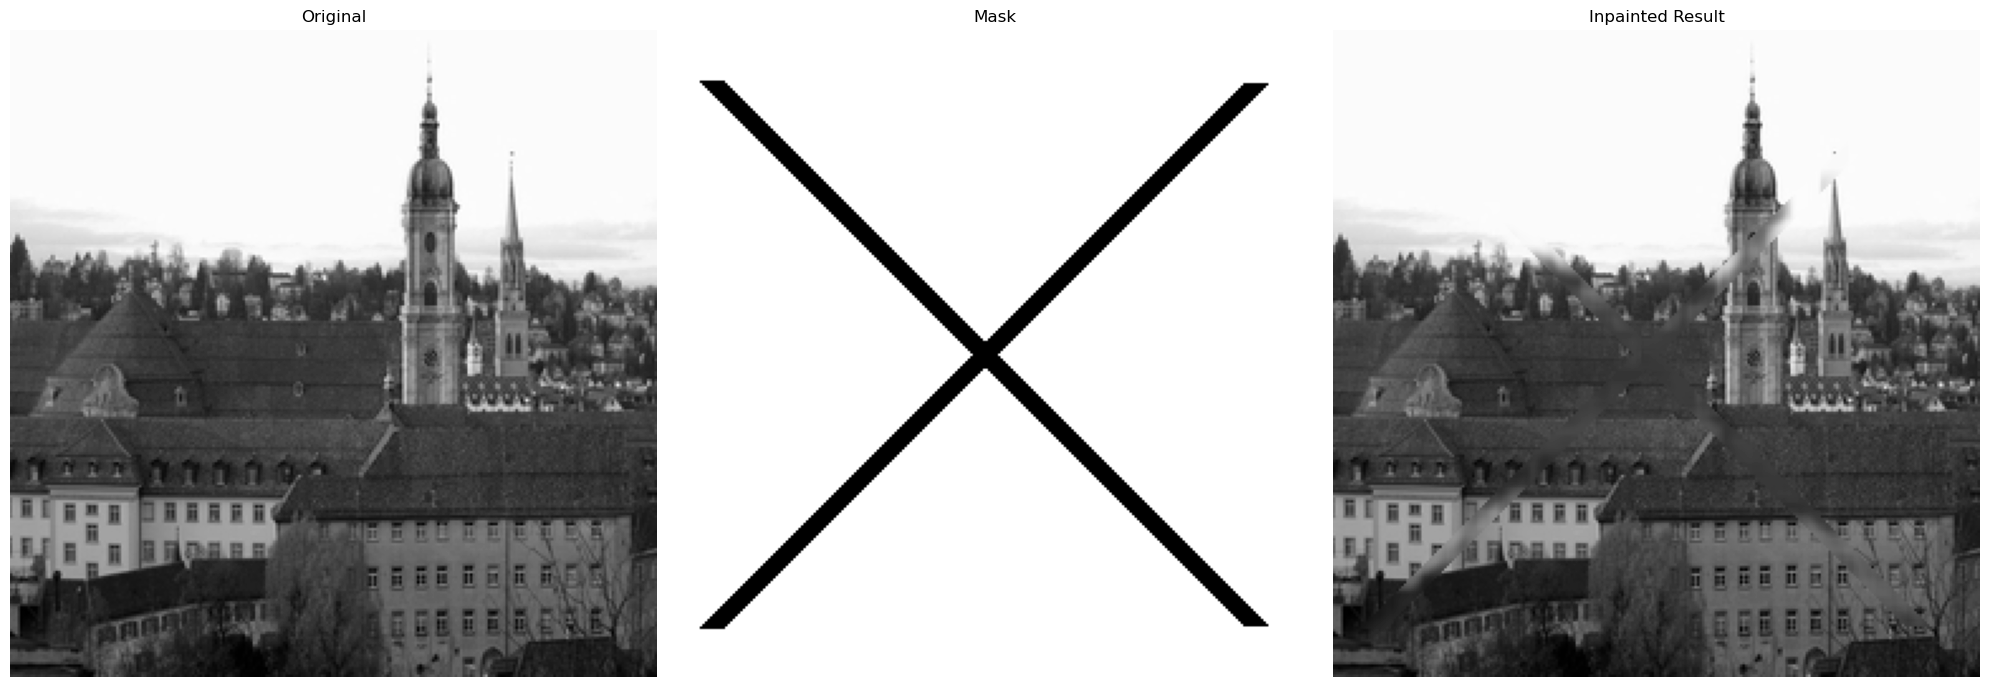

In [30]:
inpainted_image = nearestNeighbors(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, inpainted_image)

#### Gaussian Blur

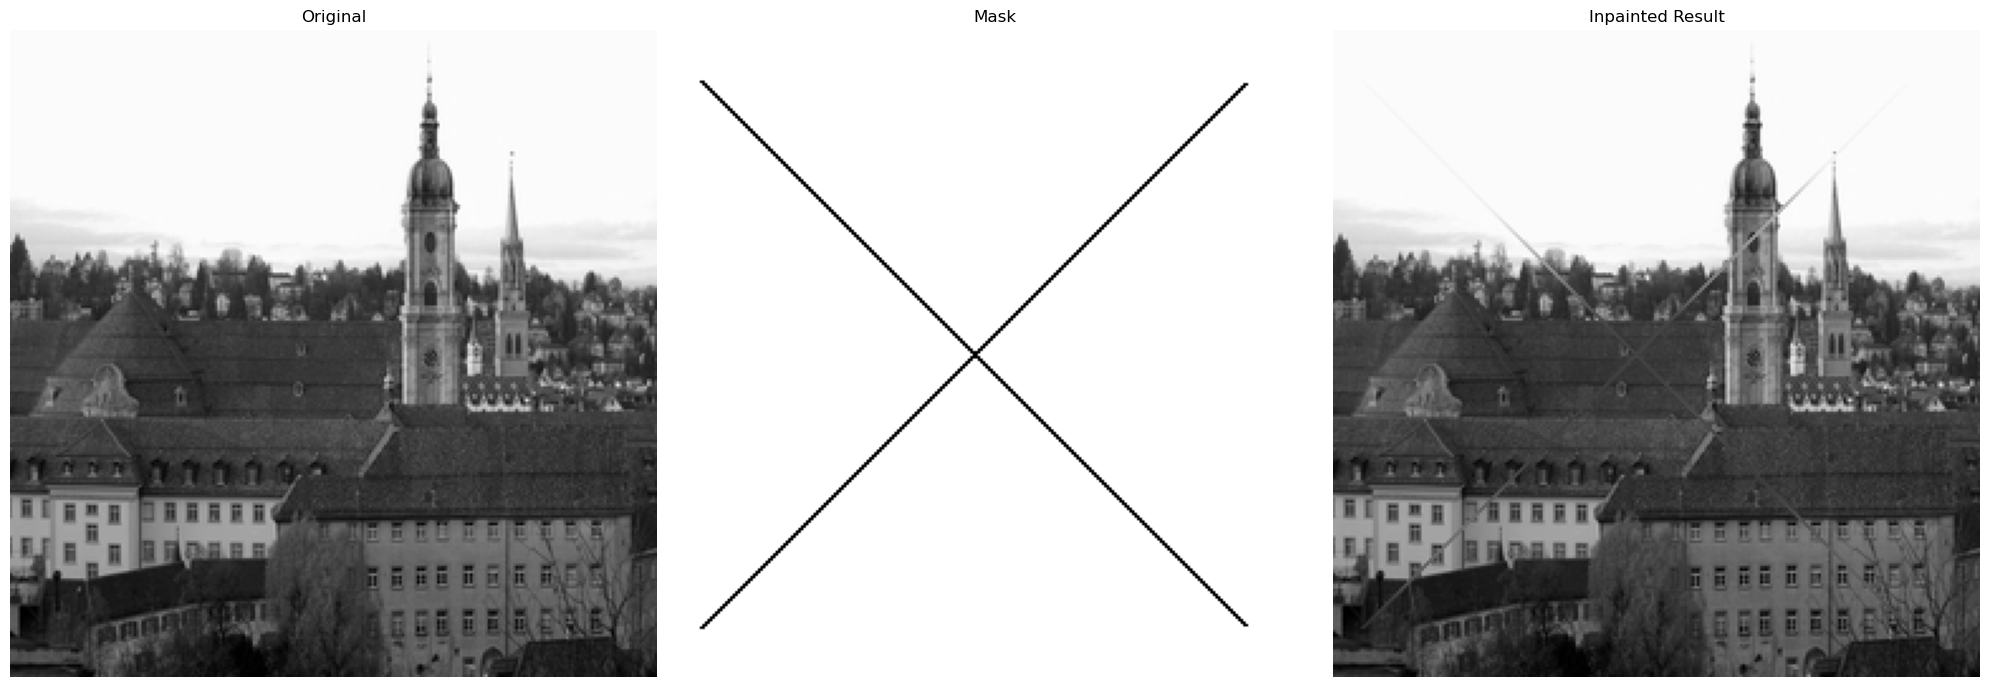

In [31]:
res = gaussianInpaint(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, res)


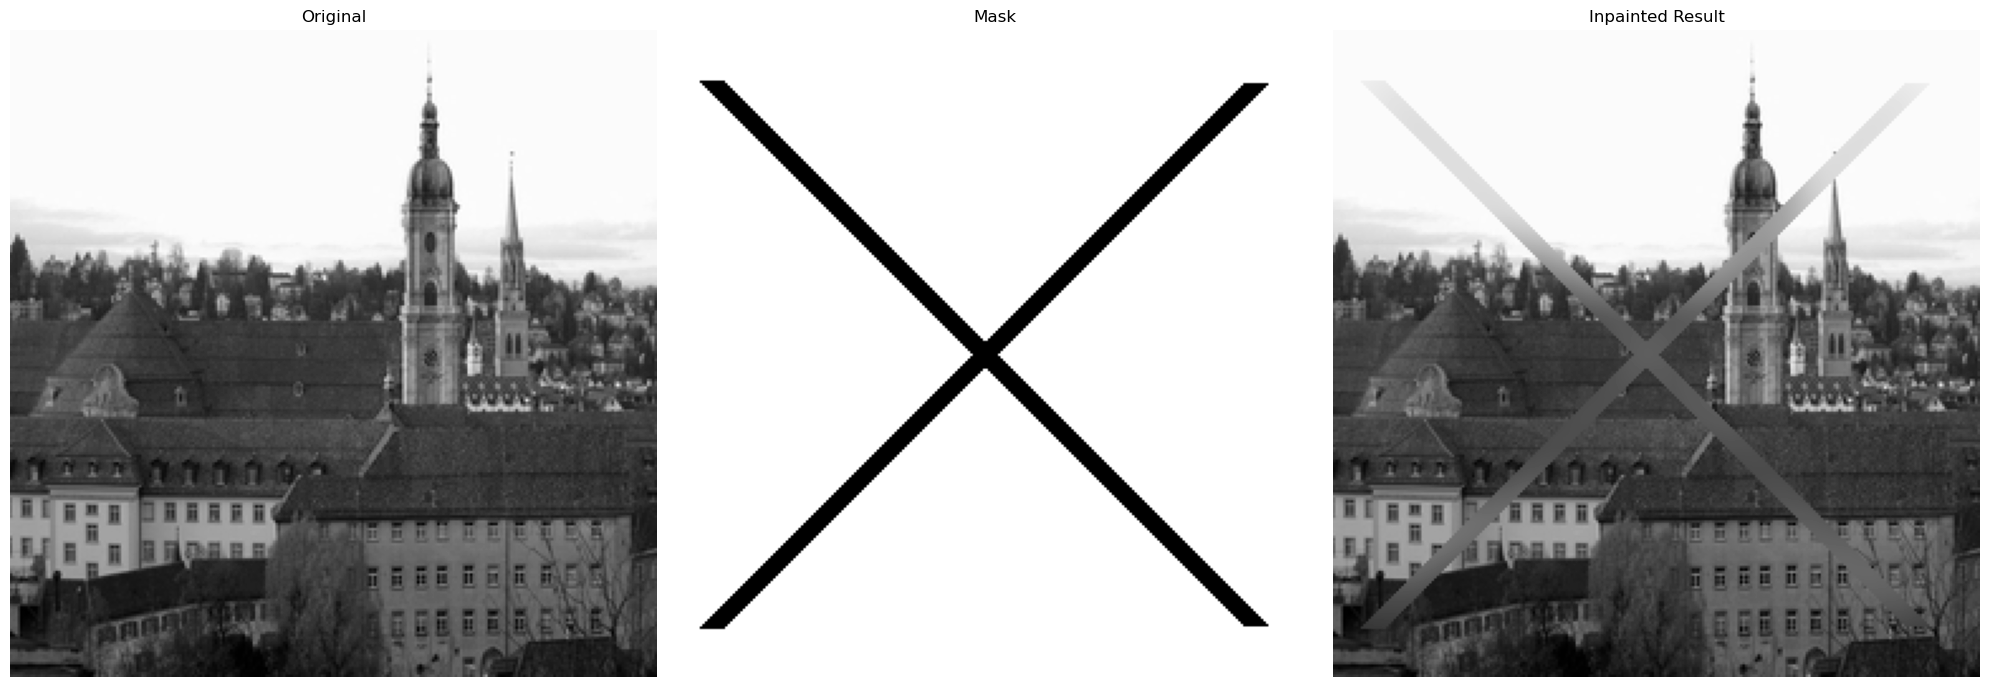

In [32]:
res = gaussianInpaint(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, res)

#### Section 3: Object removal
This section will be for patch selection:
- simple rectangle patch
- cross patch

The goal of this section is to create the dataset that is ready to be used for training/validating. for each image in the data set we should have an (img, mask) in the final dataset, ready to be trained. I

In [4]:
PATCH_SIZE = (20, 20)
PATCH_LOC = (128, 128)

ds = DatasetDownloader.get_places()
image_set = ds.images[0:2000].numpy(aslist=True)
rgb_set = list(filter(lambda x: x.shape[2] == 3,image_set)) #filtering out

rgb_set = np.array(rgb_set)
MEAN = rgb_set.mean(axis=(0, 1, 2)) / 255.0
STD = rgb_set.std(axis=(0, 1, 2)) / 255.0
print("mean of dataset:", MEAN)
print("std of dataset:", STD)

# randomly shuffle the image dataset
import random
random.seed(2024)
shuffled = rgb_set[:]
random.shuffle(shuffled)
l = len(rgb_set)
l_train = int(l * 0.8)

train_set = shuffled[0:l_train]
val_set = shuffled[l_train:]

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/places205



\

hub://activeloop/places205 loaded successfully.



mean of dataset: [0.44708346 0.45159206 0.42394301]
std of dataset: [0.27102071 0.27261193 0.30714588]


In [20]:
training_data, validation_data = shuffled[0:l_train], shuffled[l_train:]

validation_img_transform = tfs.Compose([
    RectangleMask(patch_size=PATCH_SIZE, patch_loc=PATCH_LOC),
    PairToTensors(),
    PairAddWhiteNoise(std=0.1)
])

validation_cross_img_transform = tfs.Compose([
    CrossMask(patch_size=2),
    PairToTensors(),
])

training_img_transform = tfs.Compose([
    RectangleMask(patch_size=PATCH_SIZE, patch_loc=PATCH_LOC),
    PairToTensors(),
    RandomHFlip(),
    RandomVFlip(),
    PairAddWhiteNoise(std=0.1)
])

sample_ds = CustomPlaces(data = [training_data[10]], transform=validation_img_transform)
train_ds = CustomPlaces(data = training_data, transform=training_img_transform)
validation_ds = CustomPlaces(data = validation_data, transform=validation_img_transform)
validation_cross_ds = CustomPlaces(data = validation_data, transform=validation_cross_img_transform)

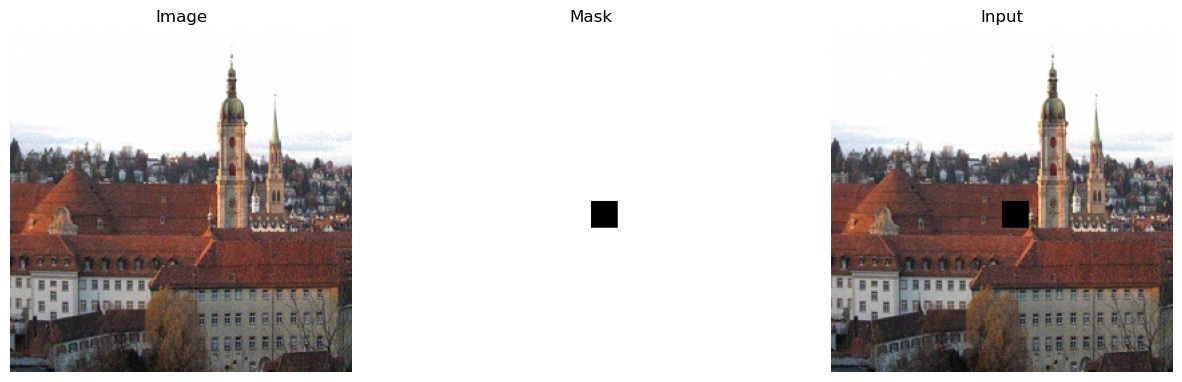

In [56]:
x = sample_ds[0]

plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(torch_image_to_numpy(x[0]), vmin=0, vmax=255)
plt.title('Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(torch_image_to_numpy(x[1]), vmin=0, vmax=255)
plt.title('Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(torch_image_to_numpy(x[0] * x[1]), vmin=0, vmax=255)
plt.title('Input')
plt.axis('off')

plt.show()

In [57]:
TRAIN_BATCH_SIZE = 20 
NUM_WORKERS = 0 #Windows bug

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(validation_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
sample_loader = DataLoader(sample_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
 

#### Section 4: Creating the  model for the network
The first simple approach would be to use an autoencoder and self-supervision to fit the model to the dataset. At first we used a basic model with layers of convolution and relu along with batch normilization to construct the layers. Furthermore we tried using max-pooling to down-sample parts of image to keep the model more focuses. As mentioned on slides from Lecture 11 we used L2 loss alongside an Adam optimizer to train the model. Below you will see the architecture of the model

In [23]:
import torch.nn as nn

class InpaintingAutoencoder(nn.Module):
    def __init__(self, input_shape: tuple[int, int], patch_size: tuple[int, int], patch_loc: tuple[int, int]):
        super().__init__()
        c, h,w = input_shape
        self.patch_size = patch_size
        self.patch_loc = patch_loc
        
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=c, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        px, py = self.patch_loc
        sx, sy = self.patch_size
        img = x.clone()
        img[:, :, px:px+sx, py:py + sy] = decoded
        return img

The dimension of the features at the deepest level of must be greater or equal to the dimensions of the patch, which is precisely what we get using an 256x256 image. This is because we want to never capture the patch itself inside of the tensors.
256x256 -> encoder -> 25 X 25 -> decoder -> 20 X 20

We then put the results on top of the original image and output it.

Below we test the output of the and untrained network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


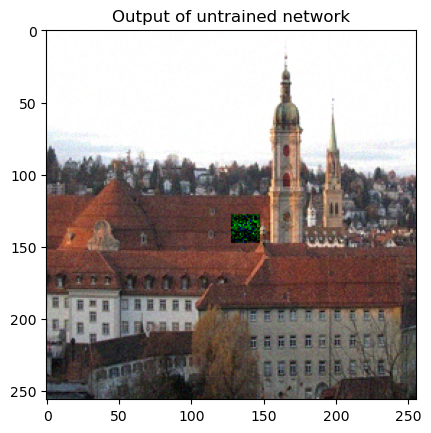

In [58]:
net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=(20, 20), patch_loc=(128, 128))
data_iter = iter(sample_loader)
data = next(data_iter)
image, mask = data
output = net.forward(image)
output = torch_image_to_numpy(output[0])

plt.imshow(output)
plt.title("Output of untrained network")
plt.show()


We tried to overfit the model to one example, to showcase it manages to behave well on one image. We use high epoch number to make sure overfitting occurs

100%|██████████| 1/1 [00:00<00:00, 61.19it/s]


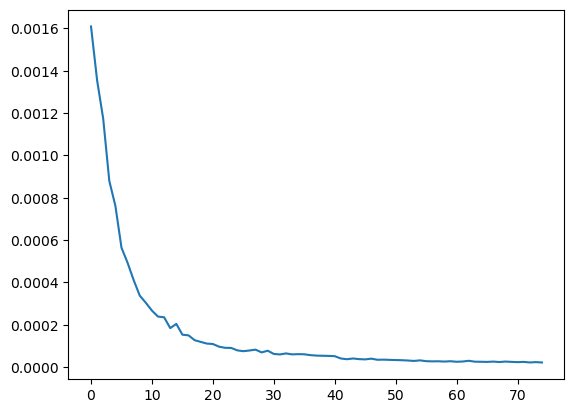

In [59]:
loss_functions = nn.MSELoss()
overfit_net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=(20, 20), patch_loc=(128, 128))
epoch = 75
loss_values = []
for e in range(epoch):
    losses = train_AE(overfit_net, sample_loader, getOptim(overfit_net, 0.0001), loss_functions, device)
    loss_values += losses

plt.plot(loss_values)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


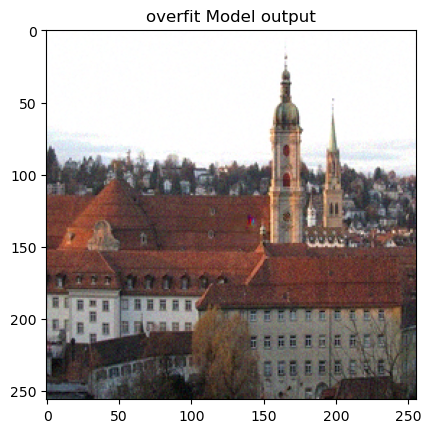

In [60]:
output = overfit_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])

plt.imshow(output)
plt.title("overfit Model output")
plt.show()

Well the overfit model seems to be working (for now).
There does seem to be a bit of random noise inside of the patch. This is the result of having too many BatchNorm layers inside of model (as we experimented). but this is a trade off that we made to achieve a better accuracy!

#### Section 4.1: Training the model, displaying the results

In [62]:
trained_net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=PATCH_SIZE, patch_loc=PATCH_LOC)
epoch = 15
loss_values = []
for e in range(epoch):
    print("epoch number:" , e)
    losses = train_AE(trained_net, train_loader, getOptim(trained_net, 0.00001), loss_functions, device)
    loss_values += losses

epoch number: 0


100%|██████████| 76/76 [00:13<00:00,  5.61it/s]


epoch number: 1


100%|██████████| 76/76 [00:13<00:00,  5.82it/s]


epoch number: 2


100%|██████████| 76/76 [00:13<00:00,  5.73it/s]


epoch number: 3


100%|██████████| 76/76 [00:13<00:00,  5.82it/s]


epoch number: 4


100%|██████████| 76/76 [00:12<00:00,  5.86it/s]


epoch number: 5


100%|██████████| 76/76 [00:12<00:00,  5.91it/s]


epoch number: 6


100%|██████████| 76/76 [00:13<00:00,  5.71it/s]


epoch number: 7


100%|██████████| 76/76 [00:13<00:00,  5.75it/s]


epoch number: 8


100%|██████████| 76/76 [00:13<00:00,  5.66it/s]


epoch number: 9


100%|██████████| 76/76 [00:13<00:00,  5.73it/s]


epoch number: 10


100%|██████████| 76/76 [00:13<00:00,  5.69it/s]


epoch number: 11


100%|██████████| 76/76 [00:13<00:00,  5.75it/s]


epoch number: 12


100%|██████████| 76/76 [00:13<00:00,  5.78it/s]


epoch number: 13


100%|██████████| 76/76 [00:13<00:00,  5.75it/s]


epoch number: 14


100%|██████████| 76/76 [00:12<00:00,  6.00it/s]


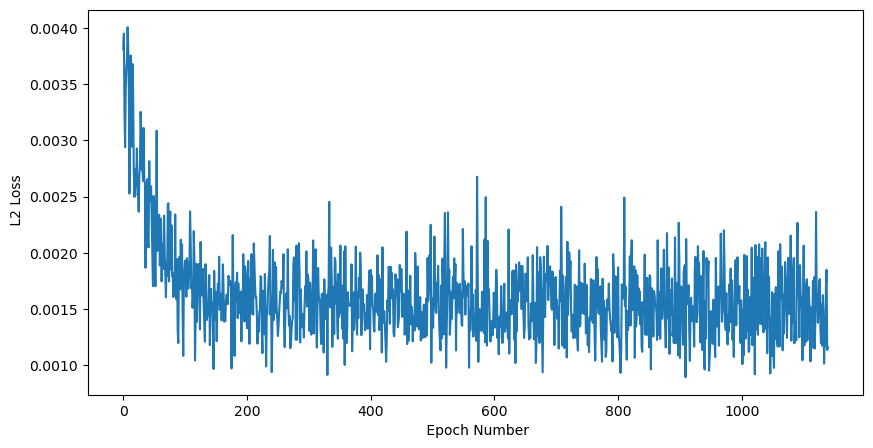

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.xlabel(" Epoch Number")
plt.ylabel(" L2 Loss")
plt.show()

The loss graph is too chaotic. It tends to go down, but in many instances, the model fails to converge to a good loss value for certain batches. Lets see how the model behaves with a training image and a validation image!

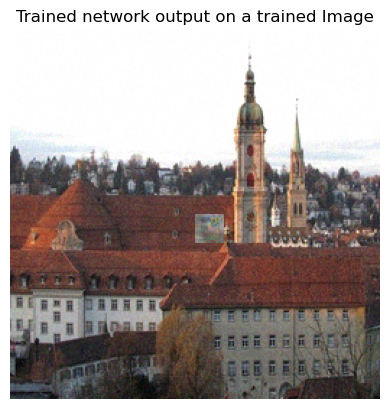

In [65]:
output = trained_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])

plt.title("Trained network output on a trained Image")
plt.axis("off")
plt.imshow(output)

(-0.5, 255.5, 255.5, -0.5)

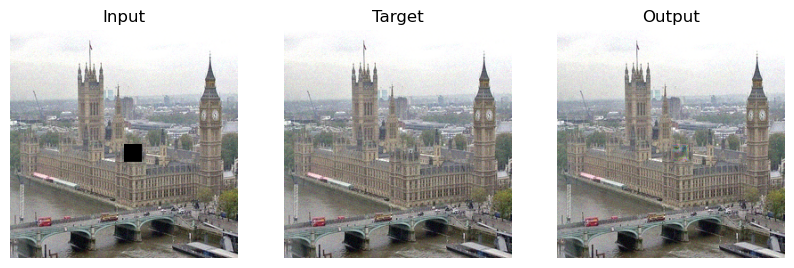

In [66]:
img2, mask2 = validation_ds[0] # will be used for sanity testing the model

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(torch_image_to_numpy(img2 * mask2))
axes[0].set_title("Input")
axes[0].axis('off')

axes[1].imshow(torch_image_to_numpy(img2))
axes[1].set_title("Target")
axes[1].axis('off')

data_iter = iter(val_loader)
data = next(data_iter)
image, mask = data
output = trained_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])

axes[2].imshow(output)
axes[2].set_title("Output")
axes[2].axis('off')

As you may see above the model failed to produce any reasonable results. At first we thought the problem was our dataset. maybe we need to normalize the data, add white noise or simply feed more data into the model in hopes of fixing the problem. Alas after numerous trials and changes to the model's parameters, we gave up and tried to research why we were not getting good results.

we found three main issues with the model: 

1) In order to fill the hole inside of the input, the model has to understand all of the image contextual features. a simple shallow auto-encoder is not able to understand these complex relationships inside of the model

2) Bootleneck size of the model is not big enough to comprehend any useful features for such high quality images

3) The loss function that we use (MSE) is only able to focus on pixel level differences. meaning semantic differences are ignored, leading to blurry and bad reconstruction of the hole. Inpainting often requires perceptual loss or adversarial loss to generate plausible textures and patterns.

### Section 5: In search of a better solution?

We have to address the problems above with one or two solutions. Luckily we weren't the first to try and tackle this problem. In the paper mentioned on Lecture 12 slides about Image inpainting, we found out how usually U-net architectures provide better results for inpainting projects [1]. In which every layer of the encoder, also sends a skip-connection to their respective decoder layer.
Below is an example Image of a network used for Image Inpainting:


<img src="images/unet-impainting.png" alt="Unet image" width="800">

This would fix our bottleneck issue by allowing us to "pass more data" around the network
The question was, would this be enough to reach our goal?
After multiple tries we were not able reach a desirable goal using this approach either. something was missing (attempts at an old-school Unet was omitted because length of the report)
That is when we stumbled upon the paper from Nvidia "Image Inpainting for Irregular Holes Using Partial Convolutions"[2]. in which they tried to use "Partial Convolution" to only a convolve a part of an Image given the required mask.

#### Section 5.1: Partial Convolotion
assume that a typical convolution filter is W and the input Image is X. then a typical Convolution layer behaves as below:
$$
    x' = conv(X, W)
$$
in Partial Convolution we only apply the convolution results to a part of Image using an mask M which is a binary matrix of 0s and 1s with the same shape as X, indicating the holes in the image. The mask itself is passed through a convolution and doesn't change the value of the mask, and serves as reshaping/copying it for further usage down the line. the equation for Partial convolotion is as below:


<img src="images/partial-conv-eq.png" alt="Unet image" width="800">

<img src="images/partial-conv-eq2.png" alt="Unet image" width="400">

The circle in the euqation indicates element-wise multiplication. The sum is to make sure we are looking at a piece of image (not a patch). 
The code below was inspired by implementation of Nvidia itself (source: https://github.com/NVIDIA/partialconv?tab=readme-ov-file)

In [37]:
"""
    a Partial convolution layer: given an image and a mask, only apply convolution results to the mask!
"""
class PartialConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernal_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__(in_channels, out_channels, kernal_size, stride=stride, padding=padding, bias=bias)
        self.mask_kernel = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1]) # indentity mask kernel
        self.update_mask = None
        self.mask_ratio = None
        torch.nn.init.xavier_uniform_(self.weight)
    
    def forward(self, img, mask):
        with torch.no_grad():
            self.mask_kernel.to(device)
            if self.mask_kernel.type() != img.type():
                self.mask_kernel = self.mask_kernel.to(img) # for some reason sometime the mask kernel was not moved to cuda correctly
            
            self.update_mask = nn.functional.conv2d(mask, self.mask_kernel
                                                    ,stride=self.stride, padding=self.padding)
            total_sum = self.mask_kernel.shape[1] * self.mask_kernel.shape[2] * self.mask_kernel.shape[3]
            self.mask_ratio = total_sum / (self.update_mask + 1e-8)
            self.update_mask = torch.clamp(self.update_mask, 0, 1)
            self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)
        
        input = torch.mul(img, mask)
        conv_res = nn.functional.conv2d(input, self.weight, self.bias, self.stride, self.padding)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(conv_res - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.mask_ratio)
        else:
            output = torch.mul(conv_res, self.mask_ratio)

        return output, self.update_mask

Now lets build a Unet architecture, but replace each convolution layer with partial convolution. the use of leaky ReLU and Upsampling was inspired by paper. furthermore notice that the network below unlike the one before, recreates all of the image, and not only the holes! This will become relevant when discussing loss functions.

In [38]:


class UpsampleConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, dec_feature, dec_mask, enc_feature, enc_mask):
        out = torch.cat([self.upsample(dec_feature), enc_feature], dim=1) # upsample and concat features
        out_mask = torch.cat([self.upsample(dec_mask), enc_mask], dim=1)  # upsample and concat masks
        return out, out_mask 


class Unet_encoder(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, batch_norm=False):
        super().__init__()
        self.conv_layer = PartialConv2d(input_ch, output_ch, kernel_size, stride, padding)
        self.active = nn.ReLU()
        self.bn = nn.BatchNorm2d(output_ch) if batch_norm else None
    
    def forward(self, x, mask):
        out, out_mask = self.conv_layer(x, mask)
        if (self.bn): # Is not None
            out = self.bn(out)
        out = self.active(out)
        return out, out_mask

class Unet_decoder(nn.Module):
    def __init__(self, input_ch, output_ch, batch_norm=False):
        super().__init__()
        self.conv_layer = PartialConv2d(input_ch, output_ch, 3, 1, 1)
        self.upsample = UpsampleConcat()
        self.active = nn.LeakyReLU(negative_slope=0.2)
        self.bn = nn.BatchNorm2d(output_ch) if batch_norm else None
    
    def forward(self, x, mask, skip_x, skip_mask):
        up, up_mask = self.upsample(x, mask, skip_x, skip_mask)
        out, out_mask = self.conv_layer(up, up_mask)
        if (self.bn): # Is not None
            out = self.bn(out)
        out = self.active(out)


        
        return out, out_mask


class Unet_Inpainter(nn.Module):
    def __init__(self, in_channel=3):
        super().__init__() 

        self.enc1 = Unet_encoder(in_channel, 64, kernel_size=7, stride=2, padding=3) 
        self.enc2 = Unet_encoder(64, 128, kernel_size=5, stride=2, padding=2, batch_norm=True)
        self.enc3 = Unet_encoder(128, 256, kernel_size=5, stride=2, padding=2, batch_norm=True)
        self.enc4 = Unet_encoder(256, 512, kernel_size=3, stride=2, padding=1, batch_norm=True)
        self.enc5 = Unet_encoder(512, 512, kernel_size=3, stride=2, padding=1, batch_norm=True)
        self.enc6 = Unet_encoder(512, 512, kernel_size=3, stride=2, padding=1, batch_norm=True)
        self.enc7 = Unet_encoder(512, 512, kernel_size=3, stride=2, padding=1, batch_norm=True)
        
        
        self.dec6 = Unet_decoder(1024, 512, batch_norm=True)
        self.dec5 = Unet_decoder(1024, 512, batch_norm=True)
        self.dec4 = Unet_decoder(1024, 512, batch_norm=True)
        self.dec3 = Unet_decoder(768, 256, batch_norm=True)
        self.dec2 = Unet_decoder(384, 128, batch_norm=True)
        self.dec1 = Unet_decoder(192, 64, batch_norm=True)

        self.final_upsample = UpsampleConcat()
        self.output_layer = PartialConv2d(67, 3, 3, 1, 1, bias=False)
        
               
        
    
    def forward(self, x):
        img, mask = x
        encd1, encd_mask1 = self.enc1(*x)
        encd2, encd_mask2 = self.enc2(encd1, encd_mask1)
        encd3, encd_mask3 = self.enc3(encd2, encd_mask2)
        encd4, encd_mask4 = self.enc4(encd3, encd_mask3)
        encd5, encd_mask5 = self.enc5(encd4, encd_mask4)
        encd6, encd_mask6 = self.enc6(encd5, encd_mask5)
        encd7, encd_mask7 = self.enc7(encd6, encd_mask6)
        
        
        decd6, decd_mask6 = self.dec6(encd7, encd_mask7, encd6, encd_mask6)
        decd5, decd_mask5 = self.dec5(decd6, decd_mask6, encd5, encd_mask5)
        decd4, decd_mask4 = self.dec4(decd5, decd_mask5, encd4, encd_mask4)
        decd3, decd_mask3 = self.dec3(decd4, decd_mask4, encd3, encd_mask3)
        decd2, decd_mask2 = self.dec2(decd3, decd_mask3, encd2, encd_mask2)
        decd1, decd_mask1 = self.dec1(decd2, decd_mask2, encd1, encd_mask1)


        
        final_up, final_up_mask = self.final_upsample(decd1, decd_mask1, img, mask)
        output, output_mask = self.output_layer(final_up, final_up_mask)
        return output, output_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


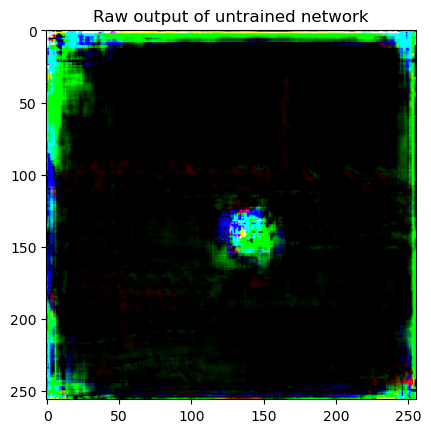

In [39]:
net = Unet_Inpainter()
data_iter = iter(sample_loader)
data = next(data_iter)

image, mask = data
output, output_mask = net.forward((image, mask))
output = torch_image_to_numpy(output[0])

plt.imshow(output)
plt.title("Raw output of untrained network")
plt.show()

#### Section5.2: What loss would we use
the Nvidia paper has section covering the loss function used in training the in-painting model. the logic behind the loss construction is as follows. our loss should achieve two things:

1) it should see if the model is able to recreate the holes correctly
2) it should see if the model is able to recreate the whole correctly

so there has to be two main parts for the loss values:
$$
    L_{hole} = \frac{1}{N_{I_{gt}}} * || (1 - M) * (I_{out} - I_{gt}) || \\
    L_{whole} = \frac{1}{N_{I_{gt}}} * || M * (I_{out} - I_{gt}) || \\
$$

Furthermore we want to make sure that our loss function also minimizes the discontinuities around the patch. so we would need and "sort of" perceptual loss. The Issue is how do we recognize deep features to access how well the patch blends into the image? Well we would need an embedding of the image into a lower dimensional space. How would we do this without training a network ourselves (we don't have the time :) )
for this task we will utilize the VGG16 pretrained model provided by torch to embed the images and then use L1 loss to calculate their difference.

<img src="images/preceptual_loss.png" alt="Unet image" width="800">

where $I_{comp}$ is our Output, $I_{gt}$ is the original Image, and $I_{out}$ the "raw" output of the model. The Psi indicates the embedding using VGG16

Furthermore the paper suggests to use "style loss" as well, which is the same as perceptual loss, but and auto correlation is also present in the equation

<img src="images/style_loss.png" alt="Unet image" width="800">

Lastly, total variation loss for penalizing non-smoothness around the patch

<img src="images/tv_loss.png" alt="Unet image" width="800">

The final loss is a linear combination of the above losses. some of them were the same that the paper used, but we changed some values to adapt the loss to our problem.

the code for the loss calculation were borrowed from the Nvidia implementation repository (source: https://github.com/NVIDIA/partialconv?tab=readme-ov-file)

#### Section 5.3: Training the Unet

100%|██████████| 120/120 [00:10<00:00, 11.83it/s]


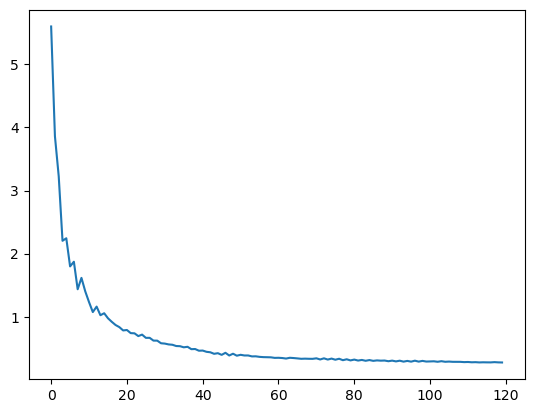

In [42]:
from partialconv_loss import InpaintingLoss, VGG16FeatureExtractor
loss_functions = InpaintingLoss(VGG16FeatureExtractor(mean=MEAN, std=STD), coefs=[1.0, 6.0, 0.05, 1.00, 0.1]).to(device)

overfit_net = Unet_Inpainter()
epoch =  120
epoch_losses = []
for e in tqdm(range(epoch)):
    losses = train_Unet(overfit_net, sample_loader, getOptim(overfit_net, 0.0001), loss_functions, device)
    epoch_losses += losses

plt.plot(epoch_losses)

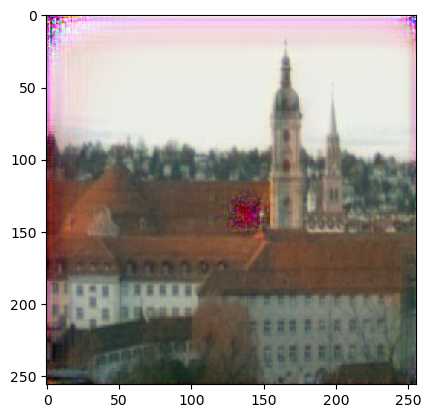

In [43]:
data_iter = iter(sample_loader)
data = next(data_iter)

image, mask = data
output, output_mask = overfit_net.forward((image.to(device), mask.to(device)))
clamped = output.cpu().squeeze().clamp(0.0, 1.0)
output = torch_image_to_numpy(clamped)
plt.imshow(output)

epoch number: 0


100%|██████████| 152/152 [00:59<00:00,  2.57it/s]


epoch number: 1


100%|██████████| 152/152 [00:59<00:00,  2.53it/s]


epoch number: 2


100%|██████████| 152/152 [00:58<00:00,  2.62it/s]


epoch number: 3


100%|██████████| 152/152 [00:58<00:00,  2.60it/s]


epoch number: 4


100%|██████████| 152/152 [00:57<00:00,  2.65it/s]


epoch number: 5


100%|██████████| 152/152 [00:57<00:00,  2.64it/s]


epoch number: 6


100%|██████████| 152/152 [00:58<00:00,  2.60it/s]


epoch number: 7


100%|██████████| 152/152 [00:59<00:00,  2.57it/s]


epoch number: 8


100%|██████████| 152/152 [00:58<00:00,  2.61it/s]


epoch number: 9


100%|██████████| 152/152 [00:58<00:00,  2.60it/s]


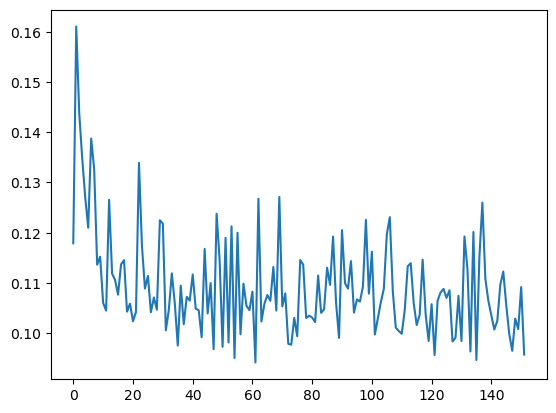

In [44]:
trained_net = Unet_Inpainter()
train_loader = DataLoader(train_ds, batch_size=10, num_workers=NUM_WORKERS, shuffle=True)
loss_functions = InpaintingLoss(VGG16FeatureExtractor(mean=MEAN, std=STD), coefs=[1.0, 6.0, 0.05, 1.00, 0.1]).to(device)
epoch =  10
loss_values = []
torch.cuda.set_per_process_memory_fraction(1.0, device=torch.device('cuda:0'))
torch.cuda.empty_cache() 
for e in range(epoch):
    print("epoch number:", e)
    losses = train_Unet(trained_net, train_loader, getOptim(trained_net, 0.0001), loss_functions, device)
    loss_values += losses

plt.plot(losses)

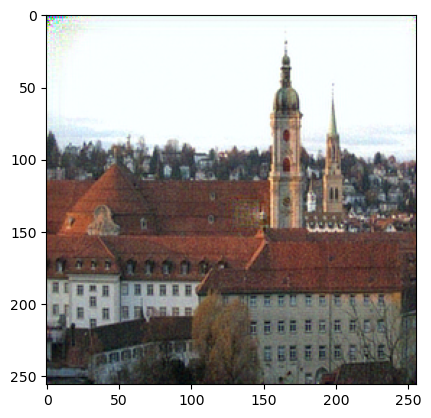

In [46]:
data_iter = iter(sample_loader)
data = next(data_iter)

image, mask = data
output, output_mask = trained_net.forward((image.to(device), mask.to(device)))
clamped = output.cpu().squeeze().clamp(0.0, 1.0)
output = torch_image_to_numpy(clamped)
plt.imshow(output)

(-0.5, 255.5, 255.5, -0.5)

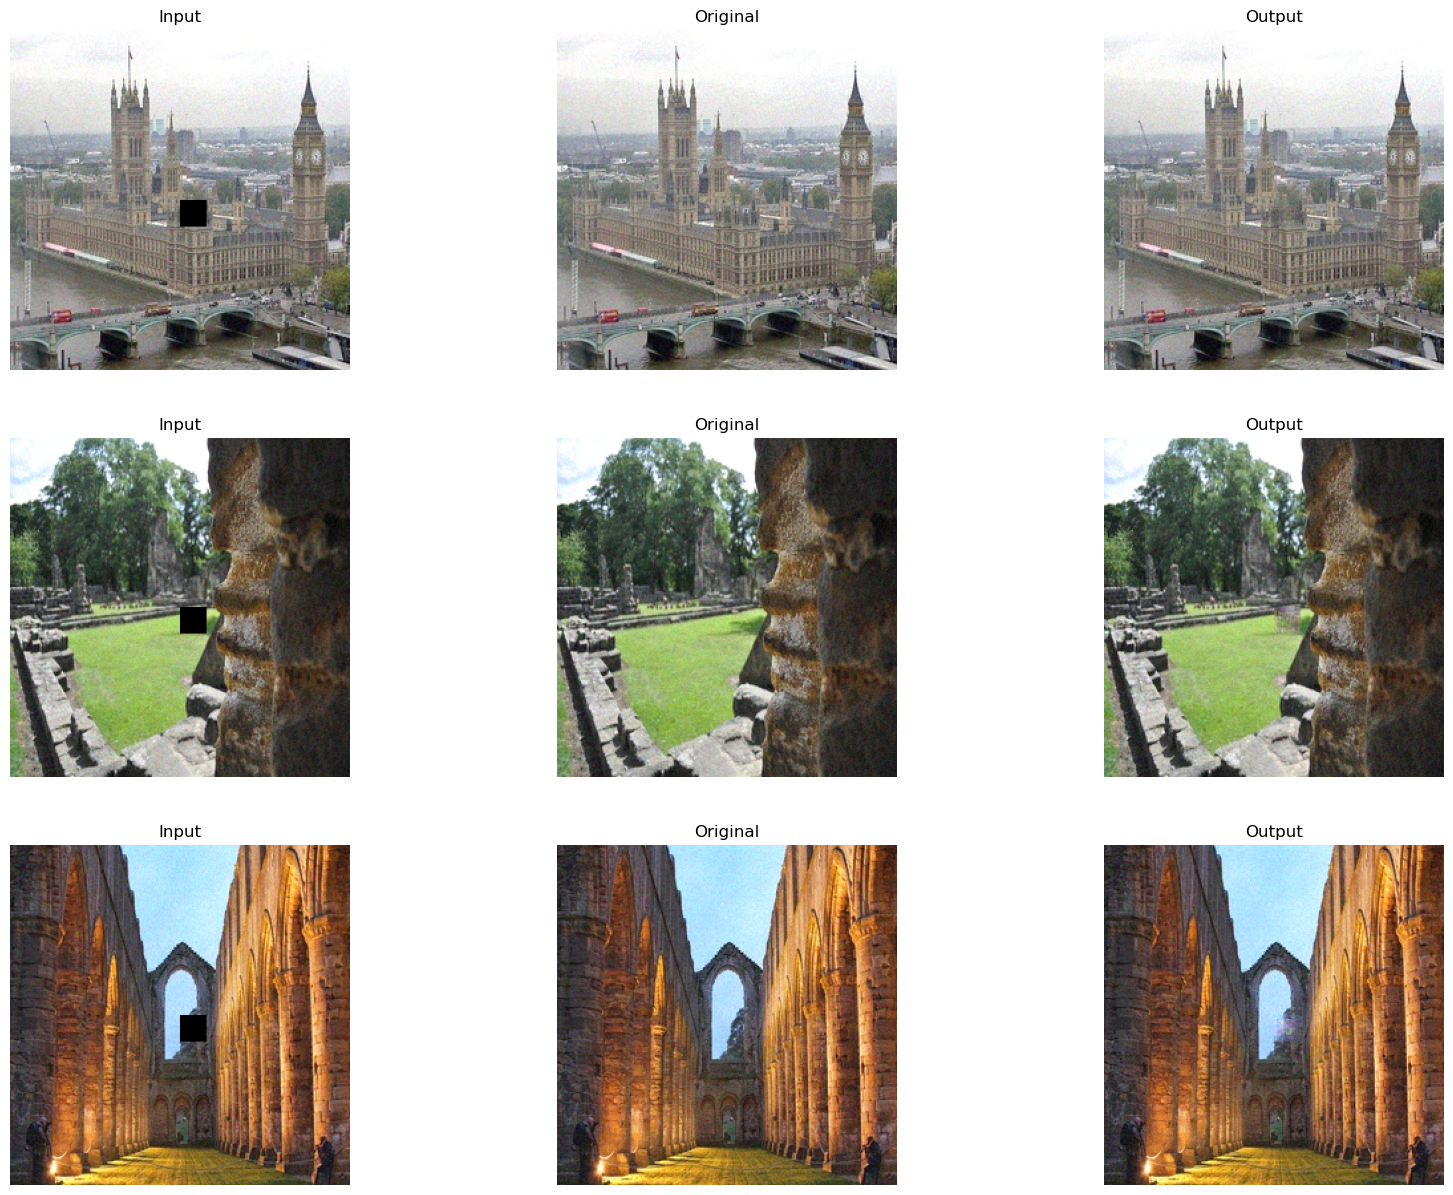

In [55]:
data_iter = iter(val_loader)
data = next(data_iter)
image, mask = data
output, output_mask = trained_net.forward((image.to(device), mask.to(device)))

fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # 1 row, 2 columns


axes[0, 0].imshow(torch_image_to_numpy(image[0] * mask[0]))
axes[0, 0].set_title("Input")
axes[0, 0].axis('off')

axes[0 ,1].imshow(torch_image_to_numpy(image[0]))
axes[0, 1].set_title("Original")
axes[0, 1].axis('off')

clamped = output.cpu().squeeze().clamp(0.0, 1.0)
clamped = clamped * (1 - mask) + image * mask
output = torch_image_to_numpy(clamped[0])
axes[0, 2].imshow(output)
axes[0, 2].set_title("Output")
axes[0, 2].axis('off')

data = next(data_iter)
image, mask = data
output, output_mask = trained_net.forward((image.to(device), mask.to(device)))

axes[1, 0].imshow(torch_image_to_numpy(image[0] * mask[0]))
axes[1, 0].set_title("Input")
axes[1, 0].axis('off')

axes[1 ,1].imshow(torch_image_to_numpy(image[0]))
axes[1, 1].set_title("Original")
axes[1, 1].axis('off')

clamped = output.cpu().squeeze().clamp(0.0, 1.0)
clamped = clamped * (1 - mask) + image * mask
output = torch_image_to_numpy(clamped[0])
axes[1, 2].imshow(output)
axes[1, 2].set_title("Output")
axes[1, 2].axis('off')


data = next(data_iter)
image, mask = data
output, output_mask = trained_net.forward((image.to(device), mask.to(device)))

axes[2, 0].imshow(torch_image_to_numpy(image[0] * mask[0]))
axes[2, 0].set_title("Input")
axes[2, 0].axis('off')

axes[2 ,1].imshow(torch_image_to_numpy(image[0]))
axes[2, 1].set_title("Original")
axes[2, 1].axis('off')

clamped = output.cpu().squeeze().clamp(0.0, 1.0)
clamped = clamped * (1 - mask) + image * mask
output = torch_image_to_numpy(clamped[0])
axes[2, 2].imshow(output)
axes[2, 2].set_title("Output")
axes[2, 2].axis('off')

#### Sectin 6: further suggestions
- Adverserial training might increase the model's accuracy to produce better results
- a Deep neural net embedding that is trained on the images from the dataset itself would be beneficial
- try experiments on datasets of different nature (faces, things with not to small details, movies etc...)

## Citations and team memeber contribution
[1]: Pathak, D., Krahenbuhl, P., Donahue, J., Darrell, T., & Efros, A. A. (2016). Context Encoders: Feature learning by inpainting. A. https://doi.org/10.1109/cvpr.2016.278
[2]: Liu, G., Reda, F. A., Shih, K. J., Wang, T., Tao, A., & Catanzaro, B. (2018). Image inpainting for irregular holes using partial convolutions. In Lecture notes in computer science (pp. 89–105). https://doi.org/10.1007/978-3-030-01252-6_6